# Use the ideas of Held (2001) to estimate the time-mean energy transport in the ocean and the atmosphere near 15 degrees latitudes. Use winds and sea surface temperature as input. Compare your results with the estimates presented in Trenberth and Fasullo (2017)


## Time-mean energy transport in ocean and atmosphere at 15 degrees latitude

## Inputs to use

* winds
* sea surface temperature

## Following Held (2001)

### Definitions

- $S_T$ = gross stability of atmosphere-ocean system
- $S_0$ = gross oceanic stability or enthalpy difference in the subtropical ocean cell
- $\xi$ = fraction of total stress exerted on the ocean
- $S_A$ = gross atmospheric stability
- $V$ = time & zonally averaged mass transport
- $\Gamma_d, \Gamma_m$ = dry and moist adiabatic lapse rate
- $y$ = distance from equator
- $c_p$ = specific heat capacity of air
- $c_o$ = specific heat capacity of water
- $\Delta T$ = surface temperature drop across the cell

---

Total energy transport is the sum of 

\begin{align}
S_T V
&= (S_0 \xi + S_A)V\\
\end{align}

The gross stability of the ocean and atmosphere can be expressed as the enthalpy differences:

$$ S_O = c_0 \Delta T $$

$$ S_A = (c_p \Delta T + L\Delta q) \approx c_p \frac{\Gamma_d}{\Gamma_m} \Delta T$$

The oceanic component dominates, i.e. $S_O \xi>S_A$. Using this approach one can determine the total energy transport by the subtropical cell in the ocean and the Hadley cell in the atmosphere.

### Time averaged poleward mass transport

In an extreme approximation, we can consider the mass transport in the atmosphere and the ocean to be equal and opposite.
Thus the poleward mass transport in the atmosphere can be approximated from the balance between Coriolis force and wind shear stress driving the Ekman transport.

$$\rho f \hat{e}_z\times \vec{u} = \frac{\partial \vec{\tau}}{\partial z}$$

$$ - \rho f v = \frac{\partial{\tau^x}}{\partial z}$$

assuming shear stress $\tau^x \to 0$ in deep oceans and by integrating along the depth $z$, we get the poleward mass transport as a function of longitude as:

$$\dot{m} =  \int \rho v\, dx\, dz = - \frac{\tau^x}{f} L_x$$

where $L_x$ is the latitude length

The wind shear stress can be expressed in terms of a drag coefficent as:

$$\tau^x = \rho_a C_D |u| u$$

Total mass transport in the ocean:

$$V =  \int \dot{m}\, a\cos\theta d\phi = \frac{L_x}{f} \int \tau^x d\phi$$

where $\phi$ is the longitude.

Average sea surface temperature drop $\Delta T$,

$$\Delta T = \frac{1}{2\Pi} \int  T(\phi, 0)  - T(\phi, \theta=15.5^0)\, d\phi$$

## Data analysis

### Constants

In [1]:
cp = 1006 # (J/kg-K) specific heat capacity of air at NTP
co = 4184 # (J/kg-K) specific heat capacity of water
dry_moist_lapse_rate_ratio = 3 # (approx.)
xi = 0.7  # Fraction of total stress exerted on the ocean (approx.)


rho_air = 1.2  # kg / m^3
C_D = 1e-3 # drag coefficient

Let us compute Coriolis parameter $f = 2 \Omega \sin \theta$ at the 15.5 degrees north.

In [2]:
import math

theta = math.radians(15.5)
Omega = 7.3e-5  # rad/s
f = 2 * Omega * math.sin(theta)
print(f"f = {f:.3e} rad / s ")

f = 3.902e-05 rad / s 


Latitude length

In [3]:
# Radius of earth
R = 6_378_137 # m


L_x = 2 * math.pi * R * math.cos(theta)
print(f"L_x = {L_x:.3f} m")

L_x = 38617506.491 m


### Dataset

We used time-averaged (over years 1960-2019) data along latitude 15.5 degrees north as input.

In [4]:
import xarray as xr

In [5]:
# Download datasets at latitudes 15.5 north and 0.5
ds = xr.open_mfdataset(
    (
        f"http://apdrc.soest.hawaii.edu:80/dods/public_data/iCOADS/enh1by1_including_prelim/{var}.mean"
        for var in ("wspd", "sst", "uwnd", "vwnd",)
    ),
    combine="by_coords"
)
ds30 = ds.sel(lat=30, method="nearest")
ds15 = ds.sel(lat=15, method="nearest")
ds00 = ds.sel(lat=0, method="nearest")
# save to disk
# ds30.to_netcdf("ds30.nc")
# ds15.to_netcdf("ds15.nc")
# ds00.to_netcdf("ds00.nc")

In [6]:
ds30 = xr.open_dataset("ds30.nc")
ds15 = xr.open_dataset("ds15.nc")
ds00 = xr.open_dataset("ds00.nc")
ds00

<xarray.Dataset>
Dimensions:  (lon: 360, time: 716)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-06-01
    lat      float64 ...
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    wspd     (time, lon) float32 ...
    sst      (time, lon) float32 ...
    uwnd     (time, lon) float32 ...
    vwnd     (time, lon) float32 ...
Attributes:
    title:          ICOADS 1-degree Enhanced
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/icoads1x1_enh_std.php
    history:        Fri Jul 19 13:26:34 HST 2019 : imported by GrADS Data Ser...

## Mass transport

Mass transport is calculated from the wind shear stress estimated from average zonal wind speeds at 15.5 N

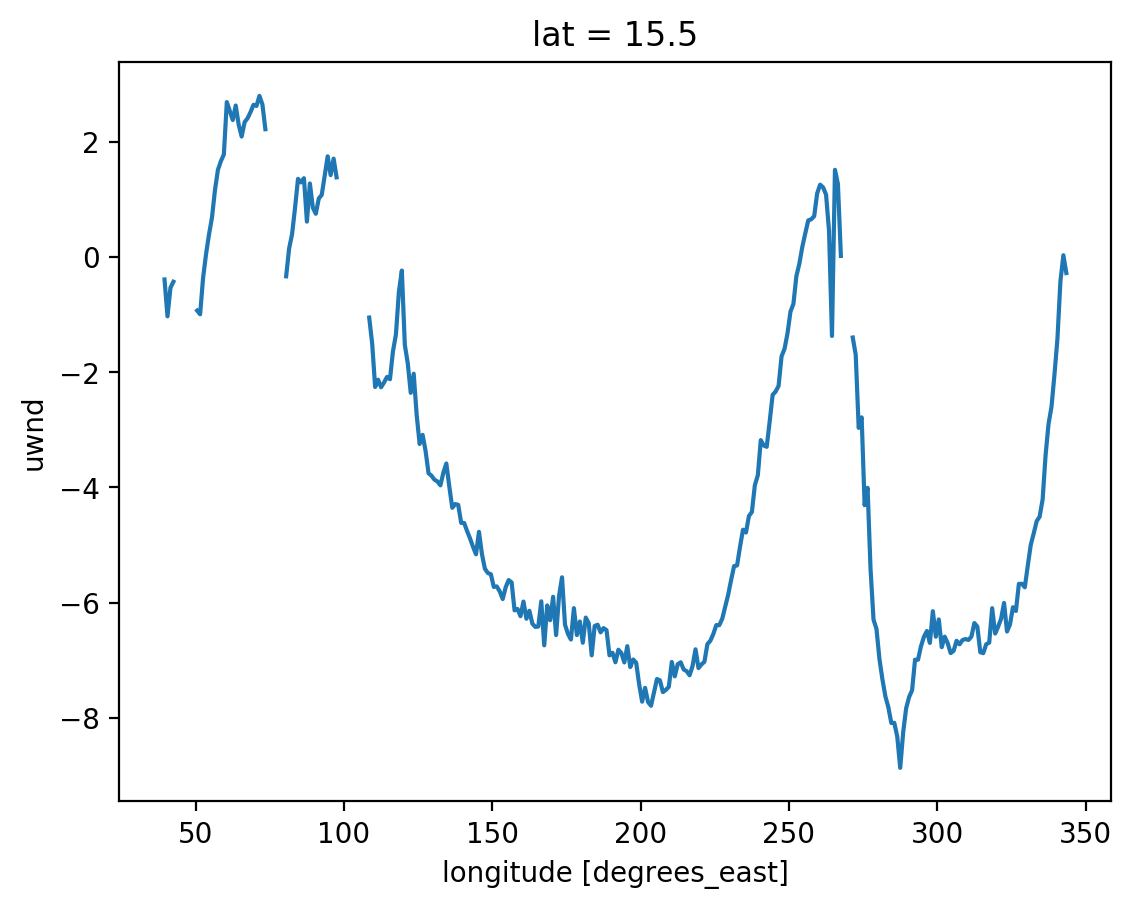

In [7]:
%%capture --no-display
%matplotlib inline
import numpy as np
import dask.array as da

ux = ds15.uwnd.mean("time", skipna=True)
ux.plot()

Text(0, 0.5, '$\\tau_x$ (Pa)')

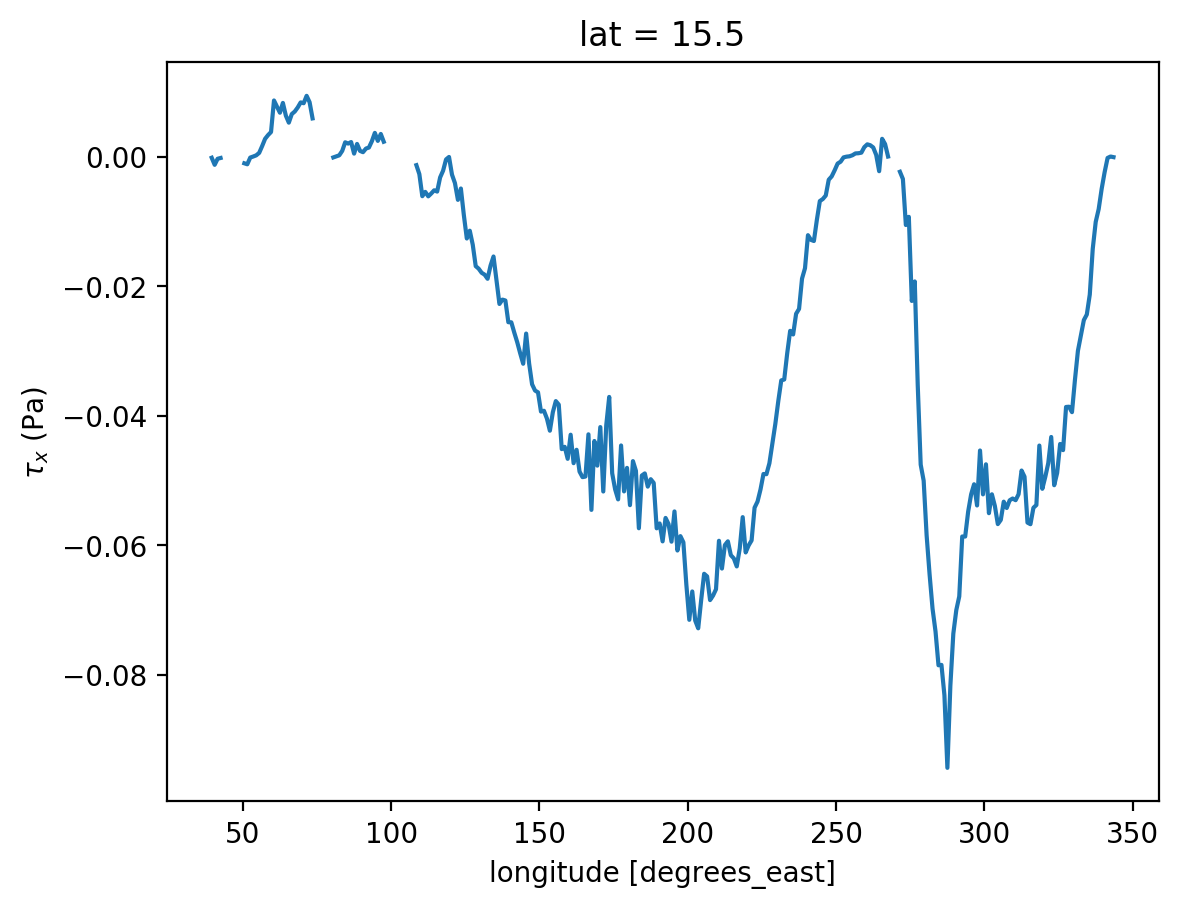

In [8]:
tau_x = rho_air * C_D * (ux ** 2 * da.sign(ux))
tau_x.plot()
ax = plt.gca()
ax.set_ylabel(r"$\tau_x$ (Pa)")

Integrate wind shear stress across the meridional direction and compute the mass transport.

In [9]:
V = L_x / f * (- tau_x.dropna("lon").integrate("lon") * (2 * math.pi / 360))
V = float(V)
print(f"V = {V:.3e} kg/s")

V = 1.437e+11 kg/s


## Sea surface temperature difference between 0.5N and 30.5 N

Text(0, 0.5, '$\\Delta T$')

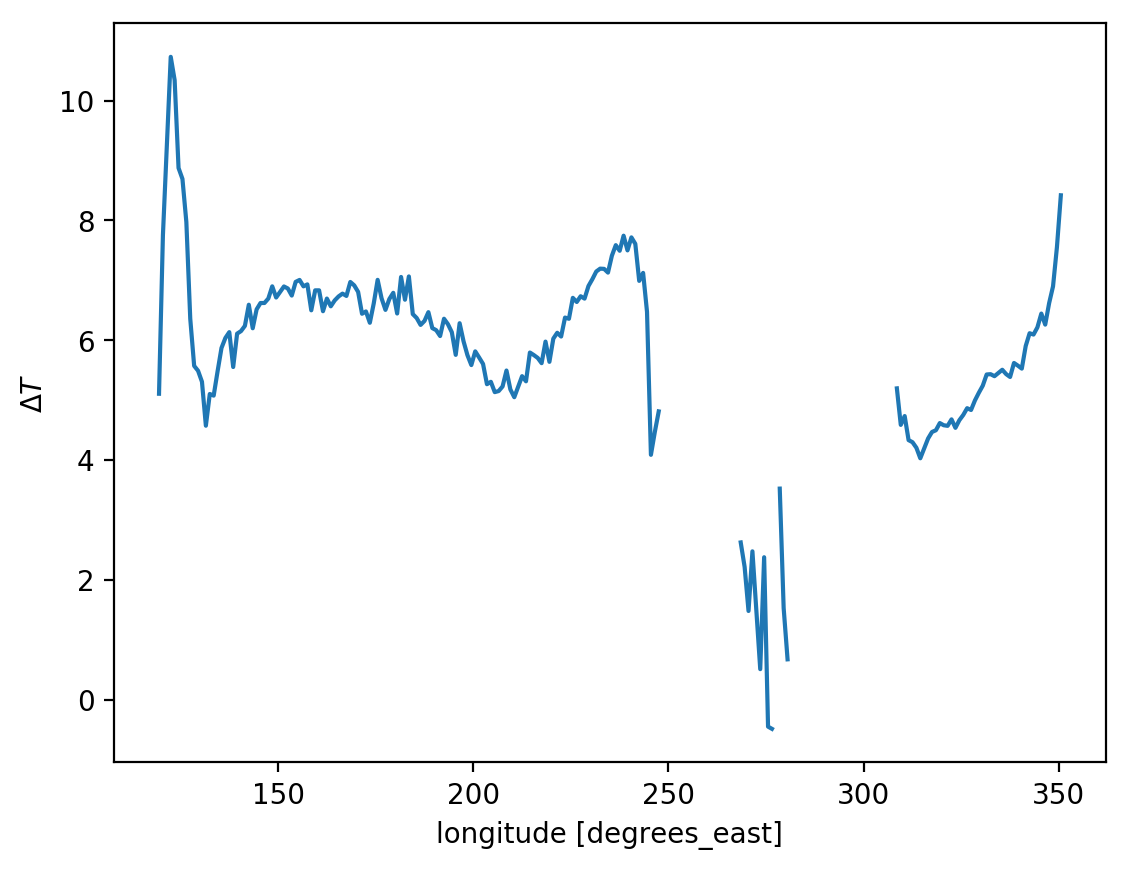

In [10]:
%%capture --no-display
dT_x = (ds00.sst - ds30.sst).mean("time", skipna=True)
dT_x.plot()
ax = plt.gca()
ax.set_ylabel(r"$\Delta T$")

Text(0.5, 0, '$\\Delta T$')

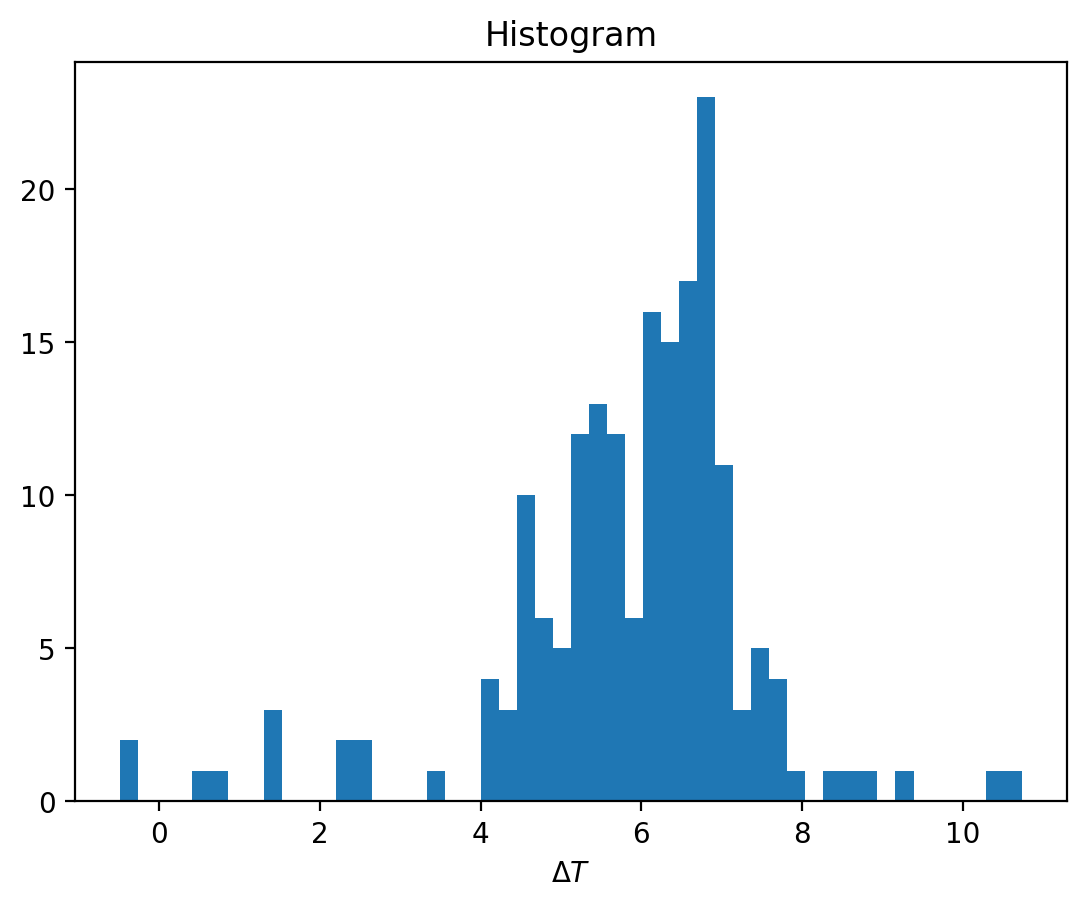

In [11]:
hist = dT_x.plot.hist(bins=50)
ax = plt.gca()
ax.set_xlabel(r"$\Delta T$")

The drop near longitude $\sim 250 E \equiv 110 W$ could be attributed to upwelling of cold water in the east coast of Central America. Since the distribution of SST is rather skewed, it might be worthwhile to use the **median** instead of mean for $\Delta T$.

In [12]:
delta_T = float(dT_x.median("lon"))
print(f"Δ𝑇 = {delta_T:.3f} K")

Δ𝑇 = 6.135 K


## Ocean

The latitude 15.5 N would correspond to a normalized latitude $y \approx 0.5$

In [13]:
y = 0.5

The energy transported by the ocean:

$$ E_O = S_O\xi V = c_0 \Delta T \xi V \left(\frac{1 + y - 2y^2}{3}\right)$$

In [14]:
E_O = co * delta_T * xi * V * (1 + y - 2 * y**2) / 3
print(f"E_O = {E_O:.2e} W")

E_O = 8.61e+14 W


The subtropical cell in the ocean is responsible for transporting $\sim 0.861$ PW of energy.

## Atmosphere

$$ E_A = S_AV \approx c_p \frac{\Gamma_d}{\Gamma_m} \Delta T V y ^2$$

In [15]:
E_A = cp * dry_moist_lapse_rate_ratio * delta_T * V * y**2
print(f"E_A = {E_A:.2e} W")

E_A = 6.65e+14 W


The Hadley cell atmosphere is responsible for transporting $\sim 0.665$ PW of energy.

## Comparison with Trenberth and Fasullo (2017)

![](trenberth_fasullo_2017-energy_transport.png)

The authors report that the total energy transport by the ocean and atmosphere
are roughly equal at 15 degrees north, and this is also what we observe. 
Also, we get estimate of the same order of magnitude (peta watts). However the 
exact value is not close to the total energy transport (for the ocean $\sim 1.8$ 
PW and $\sim 2$ PW for the atmosphere
. Possible source of errors 
in the approach following Held (2000) are:

- seasonal variations are not accounted for
- energy transport due to the subtropical ocean cell is considered,
  but deep water overturning circulation is ignored
- assumptions involved ($C_D,\,\Gamma_d/\Gamma_m, \xi$ etc.)